In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import cv2

C:\Users\kusljic\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Prvo ćemo definisati konstante koje ćemo koristiti za prediktovane klase, kao i za hiperparametre modela. Definisemo alfabet kojeg sačinjavaju nazivi vrsta cvijeća koji su dati u trening i test skupovima podataka. Takođe definišemo putanju do podataka trening skupa kao i veličinu slika koje proslijeđujemo neuronskoj mreži za klasifikaciju. Pomoćna metoda label_name_to_output za dati naziv vrste cvijeća formira vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu vrstu cvijeća.

In [2]:
ALPHABET = ["snowdrop", "lilyvalley", "bluebell", "tigerlily", "fritillary"]
ALPHABET_USER_FRIENDLY = ["Snowdrop", "Lily valley", "Bluebell", "Tiger lily", "Fritillary"]
DATADIR = "data/train"
IMAGE_SIZE = 128


def label_name_to_output(class_name):
    return [float(class_name == x) for x in ALPHABET]

name_to_out_test = "bluebell"
name_to_out_expected = [0.0, 0.0, 1.0, 0.0, 0.0]
name_to_out_res = label_name_to_output(name_to_out_test)
print("Name to output tet passed:", name_to_out_res == name_to_out_expected)

Name to output tet passed: True


Definišemo pomoćne funkcije za učitavanje slika testnog skupa podataka. Podaci prolaze pretprocesiranje tako da se svaka slika skalira na zadate dimenzije i za njenu klasu određuje se vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu klasu. Pretprocesirani podaci se cuvaju u pomocnom fajlu radi lakseg ucitavanja.

In [3]:


def load_data():
    images = []
    target_outputs = []
    train_labels = pd.read_csv(os.path.join(DATADIR, "train_labels.csv"))
    
    for img in os.listdir(DATADIR):
        if img[-4:] != ".jpg":
            continue
        
        data_instance = cv2.imread(os.path.join(DATADIR, img))  # load image
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB) # convert from BGR to RGB color model
        images.append(data_instance)
        img_label_name = train_labels.loc[train_labels['file'] == img, 'labels'].iloc[0]
        target_output = label_name_to_output(img_label_name)
        target_outputs.append(target_output)
        
    return images, target_outputs

def resize_image(image):
    return cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

def get_preprocessed_data():
    resized_images = []
    outputs = []
    preprocessed_data_file_path = os.path.join(DATADIR, "preprocessed_data.bin")
    if os.path.exists(preprocessed_data_file_path):
        preprocessed_data_file = open(preprocessed_data_file_path, "rb")
        resized_images, outputs = pickle.load(preprocessed_data_file)
        preprocessed_data_file.close()
        print("Loaded preprocessed data file.")
    else:
        # load data
        images, outputs = load_data()
        # resize images to same dimensions
        resized_images = []
        for img in images:
            resized_images.append(resize_image(img))
        # save preprocessed date to disk for easier future use
        preprocessed_data_file = open(preprocessed_data_file_path, "wb")
        preprocessed_data = (resized_images, outputs)
        pickle.dump(preprocessed_data, preprocessed_data_file)
        preprocessed_data_file.close()
        print("Created preprocessed data file.")
            
    return resized_images, outputs
        

Vršimo učitavanje i pretprocesiranje podataka koje ćemo koristiti za obučavanje konvolucione neuronske mreže
za prepoznavanje vrsta biljaka na osnovu slike cvijeta. Promjenljiva X sadrži skalirane slike iz trening skupa podataka, dok promjenljiva y sadrži očekivane predikcije neuronske mreže pri klasifikaciji.

Loaded preprocessed data file.
Samle image:


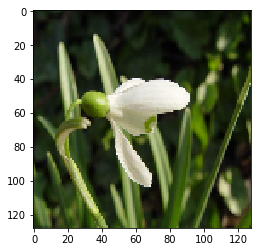

Expected output for this image: [1.0, 0.0, 0.0, 0.0, 0.0]


In [4]:
X, y = get_preprocessed_data()
print("Samle image:")
plt.imshow(X[0])
plt.show()
print("Expected output for this image:", y[0])
